In [259]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy import signal
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [153]:
data = np.loadtxt("Data/features.csv", delimiter=",")
data = data.astype(np.float32)
print(data.shape)

X_train = data[:, 1:]
y_train = data[:, 0]

print(X_train.shape)
print(y_train.shape)

test_data = np.loadtxt("Data/test_features.csv", delimiter=",")
X_test = test_data.astype(np.float32)
print(X_test.shape)

(5117, 39)
(5117, 38)
(5117,)
(3411, 38)


In [243]:
def feature_selection(X, y):
    selector = Pipeline([
        ('variance', VarianceThreshold(0.01)),
        ('univariate', SelectKBest(f_regression, k=33))
    ])
    
    X_selected = selector.fit_transform(X, y)

    return X_selected, selector

def process_features(X, is_train=True, scaler=None):
    if is_train:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled, scaler
    
    else:
        X_scaled = scaler.transform(X)
        return X_scaled

In [245]:
def train_evaluate_stacked_ensemble(X, y, n_splits=5, random_state=1):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    f1_scores = []
    current_fold = 0
    
    for train_index, val_index in kfold.split(X, y):
        # Split data

        current_fold += 1
        print(f"Fold {current_fold}")
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        X_train, scaler = process_features(X_train, is_train=True)
        X_val = process_features(X_val, is_train=False, scaler=scaler)

        svc = SVC(kernel='rbf', random_state=random_state) #0.59
        model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=random_state) #0.70
        knn = KNeighborsClassifier(n_neighbors=30) #0.59
        '''
        model = StackingClassifier(
            estimators=[
                ('svc', svc),
                ('rf', rf),
                ('knn', knn)
                ],
            final_estimator=RidgeClassifier(),
        )
        '''

        X_train, selector = feature_selection(X_train, y_train)
        X_val = selector.transform(X_val)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        f1_scores.append(f1_score(y_val, y_pred, average='micro'))

    # Calculate the mean and std for each metric across folds
    results = {'F1 Score': (np.mean(f1_scores), np.std(f1_scores))}

    # Print the results
    print("Cross-Validation Performance:")
    for metric, (mean, std) in results.items():
        print(f"{metric}: {mean:.4f} ± {std:.4f}")

In [247]:
train_evaluate_stacked_ensemble(X_train, y_train, n_splits=10, random_state=1)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
Cross-Validation Performance:
F1 Score: 0.7131 ± 0.0251


In [ ]:
'''
0.7118 ± 0.0257 - 30
0.7143 ± 0.0289 - 32
'''

In [214]:
def make_prediction_stacked_ensemble(X_train, y_train, X_test, random_state=1):
        svc = SVC(kernel='rbf', random_state=random_state) #0.59
        rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=random_state) #0.70
        knn = KNeighborsClassifier(n_neighbors=30) #0.59
        
        model = StackingClassifier(
            estimators=[
                ('svc', svc),
                ('rf', rf),
                ('knn', knn)
                ],
            final_estimator=RidgeClassifier(),
        )
        
        X_train, scaler = process_features(X_train, is_train=True)
        X_test = process_features(X_test, is_train=False, scaler=scaler)

        X_train, selector = feature_selection(X_train, y_train)
        X_test = selector.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        return y_pred,

In [216]:
def create_submission(name, X_train, y_train, X_test):
    y_pred = make_prediction_stacked_ensemble(X_train, y_train, X_test)
    
    table = pd.DataFrame({'id': np.arange(len(y_pred)), 'y': y_pred.flatten()})

    table.to_csv(f'Data/{name}.csv', index=False)

In [238]:
create_submission("submission_2", X_train, y_train, X_test)

In [261]:
#----------------------------------------


def make_prediction_visual(X, y, random_state=1):
        model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=random_state) #0.70
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

        X_train, scaler = process_features(X_train, is_train=True)
        X_test = process_features(X_test, is_train=False, scaler=scaler)

        X_train, selector = feature_selection(X_train, y_train)
        X_test = selector.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        return y_pred, y_test

In [263]:
y_1, y_2 = make_prediction_visual(X_train, y_train)

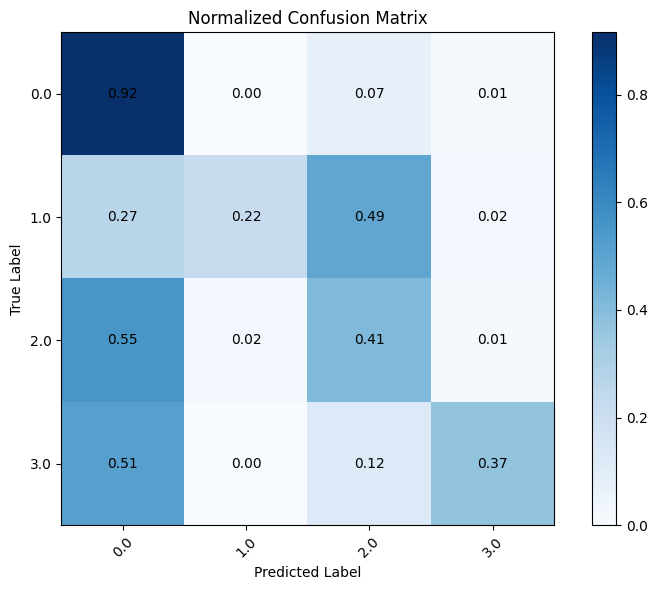

In [265]:
# Compute the confusion matrix
cm = confusion_matrix(y_2, y_1)

# Normalize the confusion matrix (Optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(im, ax=ax)

# Add labels, title, and ticks
ax.set_title("Normalized Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
classes = np.unique(y_2)  # Class labels
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Rotate tick labels for better readability
plt.xticks(rotation=45)

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, f"{cm_normalized[i, j]:.2f}", ha="center", va="center", color="black")

plt.tight_layout()
plt.show()